In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
#from netCDF4 import Dataset
import rioxarray
import geopandas as gpd
import scipy
import shapely
import datetime
from scipy.stats import gaussian_kde
from haversine import haversine, Unit
import xarray as xr
import importlib
from rasterio.transform import from_origin
from rasterio.features import geometry_mask
import sys
%matplotlib ipympl

#homebrewed 
sys.path.append('../')
import haversine2Da 

In [2]:
directory    = '/data/IMFSE/FireBehaviourModelling/Emission/GFAS/'


In [3]:
landCover = xr.open_dataset(directory+'GFED3_dominantBurningLC_version11112010_GAPFILLED.r720x360JUEL_EXTPEATOS.nc')
burninLC = landCover['dominantBurningLC'].isel(time=0)
burninLC = burninLC.rename(({"lon": "longitude", "lat": "latitude"}))
frpgfas = xr.open_dataset(directory+'GFAS-FRP-05to11-2022.nc')


In [8]:
latpx,lonpx = 41.75000000000116, 1.8500000000000005

In [11]:
burninLC.sel(latitude=latpx, longitude=lonpx,method='nearest')


<xarray.DataArray 'dominantBurningLC' ()> Size: 4B
array(1., dtype=float32)
Coordinates:
    longitude  float64 8B 1.75
    latitude   float64 8B 41.75
    time       datetime64[ns] 8B 2000-01-01
Attributes:
    long_name:    1=SA,2=SAOS,3=AG,4=AGOS,5=TF,6=PEAT,7=EF,8=EFOS
    units:        unitless
    description:  1=SA,2=SAOS,3=AG,4=AGOS,5=TF,6=PEAT,7=EF,8=EFOS
    unit:         1

Text(0.5, 1.0, 'dominant Burning Land Cover Zoomed')

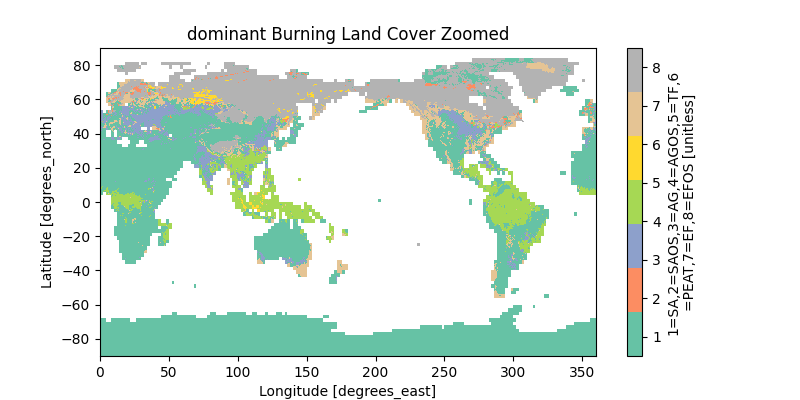

In [4]:
#plot the new map to comparw with above map
plt.figure(figsize=(8,4))
cmap = plt.get_cmap('Set2', np.unique(burninLC).shape[0]-2) # remove 0 and nan (so -2)
c=burninLC.where(burninLC!=0).plot(cmap=cmap,vmin=0.5, vmax=8.5, cbar_kwargs={'ticks':range(9)} )
plt.title('dominant Burning Land Cover Zoomed')

In [12]:
#apply roll to original resolution
burninLC_rolled = burninLC.roll(longitude=burninLC.longitude.shape[0] // 2, roll_coords=True)
burninLC_rolled.coords['longitude'] = ((burninLC_rolled.coords['longitude'] + 180) % 360) - 180

In [13]:
#define below the dominant burning land cover for a resolution 5 times higher.
# this will be needed later.

zoom_factor = 5
zoomed_data = scipy.ndimage.zoom(burninLC_rolled.data, zoom_factor, order=0)

# Czoomed_datreate new dimensions and coordinates for the zoomed array
# In this case, the coordinates will be interpolated accordingly
ddegree = 0.5
ddegree_new = ddegree/zoom_factor
correction = -1*ddegree/2+ddegree_new/2
new_x_coords = np.linspace(burninLC_rolled.coords['longitude'][0]+correction, burninLC_rolled.coords['longitude'][-1]-correction, zoomed_data.shape[1])
new_y_coords = np.linspace(burninLC_rolled.coords['latitude'][0]+correction, burninLC_rolled.coords['latitude'][-1]-correction, zoomed_data.shape[0])
new_y_coords = new_y_coords[::-1]

# Create a new DataArray with the zoomed data and adjusted coordinates
burninLC_hd_rolled = xr.DataArray(zoomed_data[::-1,:], dims={'latitude': 1800, 'longitude': 3600}, 
                                        coords={'longitude': new_x_coords, 'latitude': new_y_coords})

#
#burninLC_hd_rolled = burninLC_rolled.interp(longitude=frpgfas['longitude'], latitude=frpgfas['latitude'], method='nearest')
print( 'new shape is', burninLC_hd_rolled.shape)

new shape is (1800, 3600)


Text(0.5, 1.0, 'dominant Burning Land Cover Zoomed')

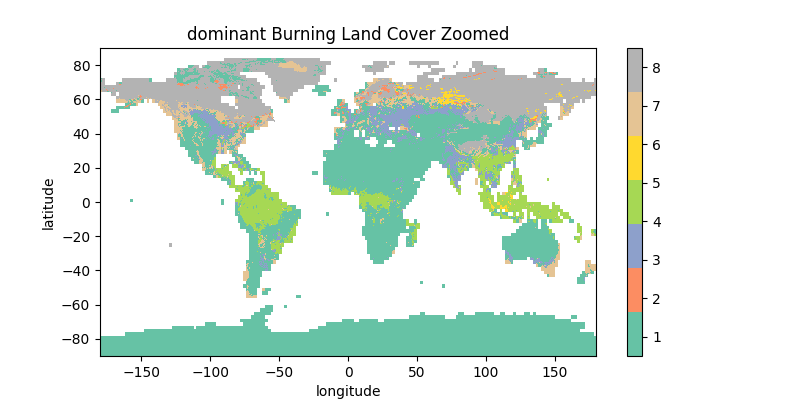

In [14]:
#plot the new map to comparw with above map
plt.figure(figsize=(8,4))
cmap = plt.get_cmap('Set2', np.unique(burninLC_hd_rolled).shape[0]-2) # remove 0 and nan (so -2)
c=burninLC_hd_rolled.where(burninLC_hd_rolled!=0).plot(cmap=cmap,vmin=0.5, vmax=8.5, cbar_kwargs={'ticks':range(9)} )
plt.title('dominant Burning Land Cover Zoomed')

In [89]:
burninLC_hd_rolled.to_netcdf(directory+'GFED3_dominantBurningLC_version11112010_GAPFILLED.r3600x1800JUEL_EXTPEATOS_rolled_rp.nc')


In [36]:
##########
#
# only zoom
#
##########

In [15]:
#define below the dominant burning land cover for a resolution 5 times higher.
# this will be needed later.

zoom_factor = 5
zoomed_data = scipy.ndimage.zoom(burninLC.data, zoom_factor, order=0)

# Czoomed_datreate new dimensions and coordinates for the zoomed array
# In this case, the coordinates will be interpolated accordingly
ddegree = 0.5
ddegree_new = ddegree/zoom_factor
correction = -1*ddegree/2+ddegree_new/2
new_x_coords = np.linspace(burninLC.coords['longitude'][0]+correction, burninLC.coords['longitude'][-1]-correction, zoomed_data.shape[1])
new_y_coords = np.linspace(burninLC.coords['latitude'][0]+correction, burninLC.coords['latitude'][-1]-correction, zoomed_data.shape[0])
new_y_coords = new_y_coords[::-1]

# Create a new DataArray with the zoomed data and adjusted coordinates
burninLC_hd = xr.DataArray(zoomed_data[::-1,:], dims={'latitude': 1800, 'longitude': 3600}, 
                                        coords={'longitude': new_x_coords, 'latitude': new_y_coords})

#
#burninLC_hd_rolled = burninLC_rolled.interp(longitude=frpgfas['longitude'], latitude=frpgfas['latitude'], method='nearest')
print( 'new shape is', burninLC_hd.shape)

new shape is (1800, 3600)


Text(0.5, 1.0, 'dominant Burning Land Cover Zoomed')

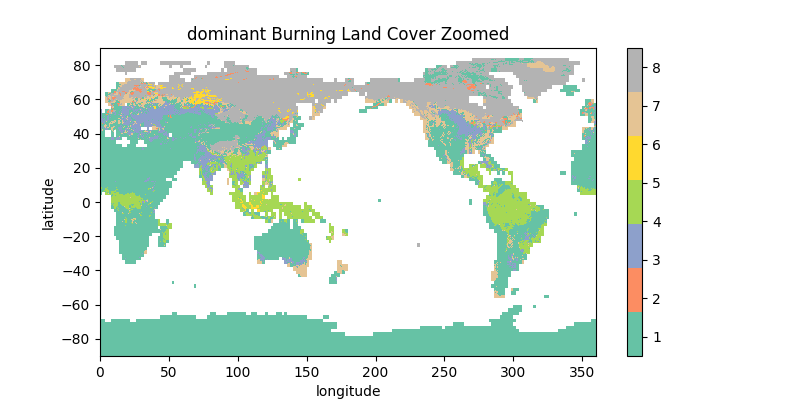

In [16]:
#plot the new map to comparw with above map
plt.figure(figsize=(8,4))
cmap = plt.get_cmap('Set2', np.unique(burninLC_hd).shape[0]-2) # remove 0 and nan (so -2)
c=burninLC_hd.where(burninLC_hd!=0).plot(cmap=cmap,vmin=0.5, vmax=8.5, cbar_kwargs={'ticks':range(9)} )
plt.title('dominant Burning Land Cover Zoomed')

In [37]:
burninLC_hd2 =  burninLC.interp(longitude=frpgfas['longitude'], latitude=frpgfas['latitude'], method='nearest')

In [38]:
print(burninLC_hd2.sel(latitude=latpx, longitude=lonpx,method='nearest').values)
print(burninLC.sel(latitude=latpx, longitude=lonpx,method='nearest').values)


1.0
1.0


In [24]:
np.abs(burninLC_hd.coords['longitude'] - lonpx).argmin(), np.abs(burninLC_hd.coords['latitude'] - latpx).argmin()

(<xarray.DataArray 'longitude' ()> Size: 8B
 array(18),
 <xarray.DataArray 'latitude' ()> Size: 8B
 array(482))

In [25]:
np.abs(burninLC.coords['longitude'] - lonpx).argmin(), np.abs(burninLC.coords['latitude'] - latpx).argmin()

(<xarray.DataArray 'longitude' ()> Size: 8B
 array(3)
 Coordinates:
     time     datetime64[ns] 8B 2000-01-01,
 <xarray.DataArray 'latitude' ()> Size: 8B
 array(263)
 Coordinates:
     time     datetime64[ns] 8B 2000-01-01)

In [32]:
burninLC.shape, burninLC_hd.shape, 263*5

((360, 720), (1800, 3600), 1315)

In [35]:
burninLC.latitude

<xarray.DataArray 'latitude' (latitude: 360)> Size: 3kB
array([-89.75, -89.25, -88.75, ...,  88.75,  89.25,  89.75])
Coordinates:
  * latitude  (latitude) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
    time      datetime64[ns] 8B 2000-01-01
Attributes:
    long_name:      Latitude
    units:          degrees_north
    standard_name:  latitude

In [93]:
burninLC_hd.to_netcdf(directory+'GFED3_dominantBurningLC_version11112010_GAPFILLED.r3600x1800JUEL_EXTPEATOS_rp.nc')


In [63]:
#test roll
burninLC_hd_rolled = burninLC_hd.roll(longitude=burninLC_hd.longitude.shape[0] // 2, roll_coords=True)
burninLC_hd_rolled.coords['longitude'] = ((burninLC_hd_rolled.coords['longitude'] + 180) % 360) - 180

In [65]:
burninLC_hd_rolled

<xarray.DataArray 'dominantBurningLC' (latitude: 1800, longitude: 3600)> Size: 26MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time       datetime64[ns] 8B 2000-01-01
  * latitude   (latitude) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * longitude  (longitude) float32 14kB -180.0 -179.9 -179.8 ... 179.9 180.0
Attributes:
    long_name:    1=SA,2=SAOS,3=AG,4=AGOS,5=TF,6=PEAT,7=EF,8=EFOS
    units:        unitless
    description:  1=SA,2=SAOS,3=AG,4=AGOS,5=TF,6=PEAT,7=EF,8=EFOS
    unit:         1

Text(0.5, 1.0, 'dominant Burning Land Cover Zoomed')

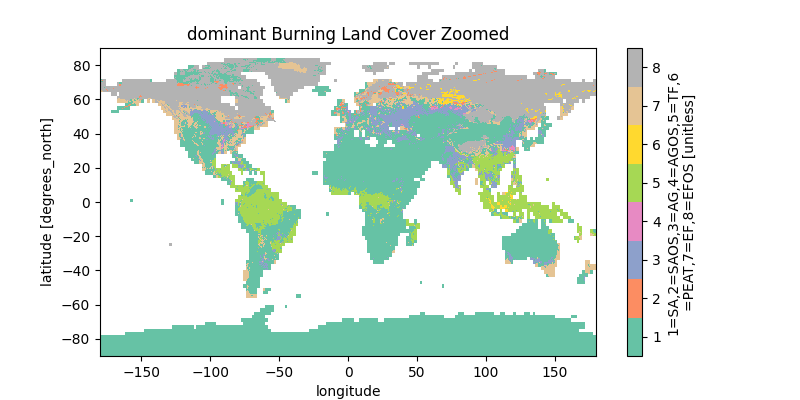

In [64]:
#plot the new map to comparw with above map
plt.figure(figsize=(8,4))
cmap = plt.get_cmap('Set2', np.unique(burninLC_hd_rolled).shape[0]-2) # remove 0 and nan (so -2)
c=burninLC_hd_rolled.where(burninLC_hd_rolled!=0).plot(cmap=cmap,vmin=0.5, vmax=8.5, cbar_kwargs={'ticks':range(9)} )
plt.title('dominant Burning Land Cover Zoomed')